# Coursework 

**Initialize packages**

In [48]:
using JuMP, HiGHS, Plots, DataFrames, CSV, Statistics

**Reading Data**

In [49]:
flex_avail = DataFrame(CSV.File("input_files/Flexible_load_availability.csv"))

Row,Column1,ev_load_shifting_z1,ev_load_shifting_z2,ev_load_shifting_z3,ev_load_shifting_z4,ev_load_shifting_z5,ev_load_shifting_z6,Column8,Column9,Column10,Column11,Column12
,Int64?,Float64,Float64,Float64,Float64,Float64,Float64,Missing,Missing,Missing,Int64?,Int64?
1,1,214.337,303.93,200.713,282.925,230.726,156.266,missing,missing,missing,missing,missing
2,2,172.924,234.819,175.68,230.498,178.382,145.876,missing,missing,missing,168,3
3,3,160.613,194.767,167.633,207.9,161.852,142.967,missing,missing,missing,168,2
4,4,156.136,178.274,164.057,194.342,152.899,137.148,missing,missing,missing,168,8
5,5,152.218,165.709,161.822,196.149,146.011,139.226,missing,missing,missing,168,3
6,6,160.053,164.138,180.15,270.27,159.097,192.008,missing,missing,missing,168,3
7,7,229.447,251.312,216.806,359.758,246.566,199.904,missing,missing,missing,168,3
8,8,256.309,314.925,237.816,423.936,269.295,223.178,missing,missing,missing,168,2
9,9,293.804,373.041,270.448,517.039,313.374,276.375,missing,missing,missing,168,5


In [50]:
flex_load = DataFrame(CSV.File("input_files/Flexible_load_data.csv"))

Row,ID,Zone_name,Zone,Load_type,Max_Capacity_MW,Max_Delay_Hrs
,Int64,String15,Int64,String31,Float64,Int64
1,1,CA_N,1,ev_load_shifting,559.626,5
2,2,CA_S,2,ev_load_shifting,785.349,5
3,3,WECC_N,3,ev_load_shifting,447.022,5
4,4,WECC_NMAZ,4,ev_load_shifting,903.914,5
5,5,WECC_PNW,5,ev_load_shifting,688.733,5
6,6,WECC_WYCO,6,ev_load_shifting,415.601,5


In [51]:
#fuels = DataFrame(CSV.File("input_files/Fuels_data.csv"));


In [52]:
generators = DataFrame(CSV.File("input_files/Generators_data.csv"))


Row,R_ID,Zone_name,Zone,Resource,Cluster,New_Build,Num_Units,Cap_size,Existing_Cap_MW,Existing_Cap_MWh,capex,Inv_cost_per_MWyr,capex_mwh,Inv_cost_per_MWhyr,Fixed_OM_cost_per_MWyr,Fixed_OM_cost_per_MWhyr,Var_OM_cost_per_MWh,Fuel,Heat_rate_MMBTU_per_MWh,heat_rate_mmbtu_mwh_iqr,heat_rate_mmbtu_mwh_std,Min_power,Ramp_Up_percentage,Ramp_Dn_percentage,Commit,Start_cost_per_MW,Start_fuel_MMBTU_per_MW,Up_time,Down_time,Charge_efficiency,Discharge_efficiency,Min_Duration,Max_Duration,THERM,VRE,MUSTRUN,STOR,HYDRO,RPS,CES,Cost_per_MMBtu
,Int64,String15,Int64,String31,String15,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Int64,Int64,Int64,Float64,String31,Float64,Int64,Int64,Float64,Float64,Float64,Int64,Int64,Float64,Int64,Int64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64
1,48,CA_N,1,new_onshore_wind,CA_N_0,1,0,0,0,0,1.15263e6,2.65727e5,0.0,0,36613,0,0.0,None,0.0,0,0,0.0,1.0,1.0,0,0,0.0,0,0,1.0,1.0,0,0,0,1,0,0,0,1,1,4.0
2,65,CA_S,2,new_utility_pv,CA_S_0,1,0,0,0,0,7.85075e5,95144.7,0.0,0,12103,0,0.0,None,0.0,0,0,0.0,1.0,1.0,0,0,0.0,0,0,1.0,1.0,0,0,0,1,0,0,0,1,1,0.0
3,79,WECC_N,3,new_onshore_wind,WECC_N_0,1,0,0,0,0,1.15263e6,1.21548e5,0.0,0,36613,0,0.0,None,0.0,0,0,0.0,1.0,1.0,0,0,0.0,0,0,1.0,1.0,0,0,0,1,0,0,0,1,1,0.0
4,117,WECC_NMAZ,4,nuclear,1,1,0,0,0,0,5.91243e6,4.80678e5,0.0,0,100888,0,2.3,rockies_uranium,10.46,0,0,0.5,0.25,0.25,1,235,0.0,24,24,1.0,1.0,0,0,1,0,0,0,0,0,1,0.69
5,120,WECC_PNW,5,new_onshore_wind,WECC_PNW_0,1,0,0,0,0,1.15263e6,1.53765e5,0.0,0,36613,0,0.0,None,0.0,0,0,0.0,1.0,1.0,0,0,0.0,0,0,1.0,1.0,0,0,0,1,0,0,0,1,1,0.0
6,143,WECC_WYCO,6,naturalgas_ccs100,0,1,0,0,0,0,1.98935e6,156779.0,0.0,0,43290,0,7.7,rockies_naturalgas_ccs100,7.86,0,0,0.6,1.0,1.0,1,87,3.5,6,6,1.0,1.0,0,0,1,0,0,0,0,0,1,4.83
7,156,CA_N,1,new_biogas_CCGT,0,1,0,0,0,0,6.56056e5,95310.0,0.0,0,7143,0,11.2,biogas,8.8,0,0,0.3,1.0,1.0,0,118,3.5,1,1,1.0,1.0,0,0,0,0,1,0,0,0,1,33.0
8,157,CA_S,2,new_biogas_CCGT,0,1,0,0,0,0,6.56056e5,95310.0,0.0,0,7143,0,11.2,biogas,8.8,0,0,0.3,1.0,1.0,0,118,3.5,1,1,1.0,1.0,0,0,0,0,1,0,0,0,1,33.0
9,158,WECC_N,3,new_biogas_CCGT,0,1,0,0,0,0,6.56056e5,95310.0,0.0,0,7143,0,11.2,biogas,8.8,0,0,0.3,1.0,1.0,0,118,3.5,1,1,1.0,1.0,0,0,0,0,1,0,0,0,1,33.0


In [53]:
gen_var = DataFrame(CSV.File("input_files/Generators_variability.csv"))
#gen_var=gen_var[:,2:39]
gen_var=gen_var[:,2:end]

Row,new_onshore_wind,new_utility_pv,new_onshore_wind_1,nuclear,new_onshore_wind_2,naturalgas_ccs100,new_biogas_CCGT,new_biogas_CCGT_1,new_biogas_CCGT_2,new_biogas_CCGT_3,new_biogas_CCGT_4,new_biogas_CCGT_5,battery
,Int64,Float64,Float64,Int64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,1,0.0,0.6609,1,0.5692,1,1,1,1,1,1,1,1
2,1,0.0,0.6048,1,0.5412,1,1,1,1,1,1,1,1
3,1,0.0,0.6184,1,0.4939,1,1,1,1,1,1,1,1
4,1,0.0,0.4097,1,0.2938,1,1,1,1,1,1,1,1
5,1,0.0,0.2867,1,0.2255,1,1,1,1,1,1,1,1
6,1,0.0,0.1609,1,0.1778,1,1,1,1,1,1,1,1
7,1,0.3553,0.0653,1,0.1225,1,1,1,1,1,1,1,1
8,1,0.6335,0.0083,1,0.0489,1,1,1,1,1,1,1,1
9,1,0.805,0.0003,1,0.0369,1,1,1,1,1,1,1,1


In [54]:
load = DataFrame(CSV.File("input_files/Load_data.csv"))
load=load[:,9:15]

Row,Time_index,Load_MW_z1,Load_MW_z2,Load_MW_z3,Load_MW_z4,Load_MW_z5,Load_MW_z6
,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,1,14798,20766,10016,21047,18287,11857
2,2,14215,19948,9738,20346,17685,11655
3,3,13688,19209,9532,19694,17323,11567
4,4,13300,18627,9474,19307,17231,11492
5,5,12304,17119,9562,19008,17345,11583
6,6,10358,14787,9626,17974,17596,11430
7,7,8490,12581,9911,17970,18129,11391
8,8,7374,11300,10511,19037,19330,11946
9,9,7250,10964,11136,20430,20666,12388


In [55]:
network = DataFrame(CSV.File("input_files/Network.csv"))

Row,Transmission Path Name,Network_lines,z1,z2,z3,z4,z5,z6,Line_Max_Flow_MW,Distance_mile,Line_Loss_Percentage,Line_Max_Reinforcement_MW,Line_Reinforcement_Cost_per_MW_yr
,String31,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Int64,Int64
1,CA_N_to_CA_S,1,1,-1,0,0,0,0,3675,333.6,0.0334,3675,90280
2,CA_N_to_WECC_N,2,1,0,-1,0,0,0,100,490.7,0.0491,100,92347
3,CA_S_to_WECC_N,3,0,1,-1,0,0,0,1920,555.9,0.0556,1400,104618
4,CA_S_to_WECC_NMAZ,4,0,1,0,-1,0,0,10464,446.7,0.0447,10464,84067
5,WECC_N_to_WECC_NMAZ,5,0,0,1,-1,0,0,800,598.8,0.0599,740,63333
6,WECC_N_to_WECC_WYCO,6,0,0,1,0,0,-1,6350,384.3,0.0384,4150,40646
7,WECC_NMAZ_to_WECC_WYCO,7,0,0,0,1,0,-1,664,485.2,0.0485,664,51318
8,CA_N_to_WECC_PNW,8,1,0,0,0,-1,0,4200,249.5,0.025,3675,46955
9,CA_S_to_WECC_PNW,9,0,1,0,0,-1,0,2858,401.5,0.0402,2858,75560


In [56]:
# Extract row indices based on New_Build values
indices_new_build_1 = findall(generators.New_Build .== 1).+1
#indices_new_build_minus1 = findall(generators.New_Build .== -1).+1;
#ndices_new_build_0 = findall(generators.New_Build .== 0).+1;

13-element Vector{Int64}:
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 14

### Problem formulation
The objective function will be:
$\begin{align}
\min &\sum_{g \in Gen} FixedCost_g \times CAP_g + \sum_{g\in Gen}\sum_{h \in H} VarCost_g \times GEN_{g,h} +\\[6pt]
&\quad\quad \sum_{h \in H} NSECost \times NSE_h &\\
\end{align}$

s.t. the constraints
$\begin{align}
&\text{Supply demand balance constraint:}&\\[6pt]
&\sum_{g \in NEW} CAP_{g,h,j} + \sum_{s \in STOR} (DISCHARGE_{s,h,j} -CHARGE_{s,h,j} ) + &\\
& NSE_{h,j} - Demand_{h,j} + FShift_{h,j} -PShift_{h,j} = \sum_{j \in J_i} FLOW_{ij} & \forall \quad i \in \mathcal{N}\\
\end{align}$


$\begin{align}
&\text{Thermal limit constraint:}&\\[6pt]
& FLOW_{ij} \leq MaxFlow_{ij} & \forall \quad i \in \mathcal{N}, \forall j \in J_i \\
&\text{Flow direction constraint:}&\\[6pt]
& FLOW_{ij} = - FLOW_{ji} & \forall \quad i, j \in \mathcal{N} \\
\end{align}
$

$\begin{align}
&\text{Capacity constraint for new generators:}&\\[6pt]
& 0 \leq  GEN_{g,h} \leq CAP_g \times CF_{g,h} & \forall \quad g \in NEW, h \in H\\[6pt]
&\text{Capacity constraint for nuclear:}&\\[6pt]
& GEN_{Nuclear,h} = CAP_{Nuclear} & \forall h \in H\\[6pt]
&\text{Capacity variable only for new build:}&\\[6pt]
& CAP_{g} \geq 0 & \forall \quad g \in NEW\\[6pt]
&\text{NSE constraint:}&\\[6pt]
& NSE_{h} \geq 0 & \forall \quad h \in H
\end{align}$

$\begin{align}
&\text{Charging and discharging constraint for storage:}&\\[6pt]
& 0 \leq CHARGE_{s,h} \leq CAP_s  & \forall \quad s \in STOR,  h \in H\\[6pt]
& 0 \leq DISCHARGE_{s,h} \leq CAP_s  & \forall \quad s \in STOR,  h \in H\\[6pt]
& 0 \leq SOC_{s,h} \leq SOC_{s}^{max}& \forall \quad s \in S, h \in H\\[6pt]
& SOC_{s,1} = SOC_{s,t_{end}} = 50\% *SOC_{s}^{max}& \forall \quad s \in S\\[6pt]
&\text{Efficiency of storage constraint:}&\\[6pt]
& SOC_{s,h}=SOC_{s,h-1} + \big(CHARGE_{s,h} * Eff_s - \frac{DISCHARGE_{s,h}}{Eff_s}\big)  & \forall \quad s \in S, h \in H \setminus {1} \\[6pt]
\end{align}$


**SETS**

**CASE 1: NO FLEXIBILITY**

**Sets**

In [57]:
# The set of hours in the demand DataFrame
H = load.Time_index # same for every zone

8736-element Vector{Int64}:
    1
    2
    3
    4
    5
    6
    7
    8
    9
   10
   11
   12
   13
    ⋮
 8725
 8726
 8727
 8728
 8729
 8730
 8731
 8732
 8733
 8734
 8735
 8736

In [58]:
H_2 = H[2:end]

8735-element Vector{Int64}:
    2
    3
    4
    5
    6
    7
    8
    9
   10
   11
   12
   13
   14
    ⋮
 8725
 8726
 8727
 8728
 8729
 8730
 8731
 8732
 8733
 8734
 8735
 8736

In [59]:
# The set of generators from the generators DataFrame
generators_new = generators[generators.New_Build .== 1, :]

Row,R_ID,Zone_name,Zone,Resource,Cluster,New_Build,Num_Units,Cap_size,Existing_Cap_MW,Existing_Cap_MWh,capex,Inv_cost_per_MWyr,capex_mwh,Inv_cost_per_MWhyr,Fixed_OM_cost_per_MWyr,Fixed_OM_cost_per_MWhyr,Var_OM_cost_per_MWh,Fuel,Heat_rate_MMBTU_per_MWh,heat_rate_mmbtu_mwh_iqr,heat_rate_mmbtu_mwh_std,Min_power,Ramp_Up_percentage,Ramp_Dn_percentage,Commit,Start_cost_per_MW,Start_fuel_MMBTU_per_MW,Up_time,Down_time,Charge_efficiency,Discharge_efficiency,Min_Duration,Max_Duration,THERM,VRE,MUSTRUN,STOR,HYDRO,RPS,CES,Cost_per_MMBtu
,Int64,String15,Int64,String31,String15,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Int64,Int64,Int64,Float64,String31,Float64,Int64,Int64,Float64,Float64,Float64,Int64,Int64,Float64,Int64,Int64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64
1,48,CA_N,1,new_onshore_wind,CA_N_0,1,0,0,0,0,1.15263e6,2.65727e5,0.0,0,36613,0,0.0,None,0.0,0,0,0.0,1.0,1.0,0,0,0.0,0,0,1.0,1.0,0,0,0,1,0,0,0,1,1,4.0
2,65,CA_S,2,new_utility_pv,CA_S_0,1,0,0,0,0,7.85075e5,95144.7,0.0,0,12103,0,0.0,None,0.0,0,0,0.0,1.0,1.0,0,0,0.0,0,0,1.0,1.0,0,0,0,1,0,0,0,1,1,0.0
3,79,WECC_N,3,new_onshore_wind,WECC_N_0,1,0,0,0,0,1.15263e6,1.21548e5,0.0,0,36613,0,0.0,None,0.0,0,0,0.0,1.0,1.0,0,0,0.0,0,0,1.0,1.0,0,0,0,1,0,0,0,1,1,0.0
4,117,WECC_NMAZ,4,nuclear,1,1,0,0,0,0,5.91243e6,4.80678e5,0.0,0,100888,0,2.3,rockies_uranium,10.46,0,0,0.5,0.25,0.25,1,235,0.0,24,24,1.0,1.0,0,0,1,0,0,0,0,0,1,0.69
5,120,WECC_PNW,5,new_onshore_wind,WECC_PNW_0,1,0,0,0,0,1.15263e6,1.53765e5,0.0,0,36613,0,0.0,None,0.0,0,0,0.0,1.0,1.0,0,0,0.0,0,0,1.0,1.0,0,0,0,1,0,0,0,1,1,0.0
6,143,WECC_WYCO,6,naturalgas_ccs100,0,1,0,0,0,0,1.98935e6,156779.0,0.0,0,43290,0,7.7,rockies_naturalgas_ccs100,7.86,0,0,0.6,1.0,1.0,1,87,3.5,6,6,1.0,1.0,0,0,1,0,0,0,0,0,1,4.83
7,156,CA_N,1,new_biogas_CCGT,0,1,0,0,0,0,6.56056e5,95310.0,0.0,0,7143,0,11.2,biogas,8.8,0,0,0.3,1.0,1.0,0,118,3.5,1,1,1.0,1.0,0,0,0,0,1,0,0,0,1,33.0
8,157,CA_S,2,new_biogas_CCGT,0,1,0,0,0,0,6.56056e5,95310.0,0.0,0,7143,0,11.2,biogas,8.8,0,0,0.3,1.0,1.0,0,118,3.5,1,1,1.0,1.0,0,0,0,0,1,0,0,0,1,33.0
9,158,WECC_N,3,new_biogas_CCGT,0,1,0,0,0,0,6.56056e5,95310.0,0.0,0,7143,0,11.2,biogas,8.8,0,0,0.3,1.0,1.0,0,118,3.5,1,1,1.0,1.0,0,0,0,0,1,0,0,0,1,33.0


In [60]:
# Storage
storage = generators_new[generators_new.Resource .== "battery", :]

Row,R_ID,Zone_name,Zone,Resource,Cluster,New_Build,Num_Units,Cap_size,Existing_Cap_MW,Existing_Cap_MWh,capex,Inv_cost_per_MWyr,capex_mwh,Inv_cost_per_MWhyr,Fixed_OM_cost_per_MWyr,Fixed_OM_cost_per_MWhyr,Var_OM_cost_per_MWh,Fuel,Heat_rate_MMBTU_per_MWh,heat_rate_mmbtu_mwh_iqr,heat_rate_mmbtu_mwh_std,Min_power,Ramp_Up_percentage,Ramp_Dn_percentage,Commit,Start_cost_per_MW,Start_fuel_MMBTU_per_MW,Up_time,Down_time,Charge_efficiency,Discharge_efficiency,Min_Duration,Max_Duration,THERM,VRE,MUSTRUN,STOR,HYDRO,RPS,CES,Cost_per_MMBtu
,Int64,String15,Int64,String31,String15,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Int64,Int64,Int64,Float64,String31,Float64,Int64,Int64,Float64,Float64,Float64,Int64,Int64,Float64,Int64,Int64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64
1,58,CA_N,1,battery,1,1,0,0,0,0,328200.0,37613.0,1.00267e5,11491,8205,2506,0.0,None,0.0,0,0,0.0,1.0,1.0,0,0,0.0,0,0,0.92,0.92,1,10,0,0,0,2,0,0,1,0.0


In [61]:
gen = generators_new[generators_new.Resource .!= "battery", :]

Row,R_ID,Zone_name,Zone,Resource,Cluster,New_Build,Num_Units,Cap_size,Existing_Cap_MW,Existing_Cap_MWh,capex,Inv_cost_per_MWyr,capex_mwh,Inv_cost_per_MWhyr,Fixed_OM_cost_per_MWyr,Fixed_OM_cost_per_MWhyr,Var_OM_cost_per_MWh,Fuel,Heat_rate_MMBTU_per_MWh,heat_rate_mmbtu_mwh_iqr,heat_rate_mmbtu_mwh_std,Min_power,Ramp_Up_percentage,Ramp_Dn_percentage,Commit,Start_cost_per_MW,Start_fuel_MMBTU_per_MW,Up_time,Down_time,Charge_efficiency,Discharge_efficiency,Min_Duration,Max_Duration,THERM,VRE,MUSTRUN,STOR,HYDRO,RPS,CES,Cost_per_MMBtu
,Int64,String15,Int64,String31,String15,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Int64,Int64,Int64,Float64,String31,Float64,Int64,Int64,Float64,Float64,Float64,Int64,Int64,Float64,Int64,Int64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64
1,48,CA_N,1,new_onshore_wind,CA_N_0,1,0,0,0,0,1.15263e6,2.65727e5,0.0,0,36613,0,0.0,None,0.0,0,0,0.0,1.0,1.0,0,0,0.0,0,0,1.0,1.0,0,0,0,1,0,0,0,1,1,4.0
2,65,CA_S,2,new_utility_pv,CA_S_0,1,0,0,0,0,7.85075e5,95144.7,0.0,0,12103,0,0.0,None,0.0,0,0,0.0,1.0,1.0,0,0,0.0,0,0,1.0,1.0,0,0,0,1,0,0,0,1,1,0.0
3,79,WECC_N,3,new_onshore_wind,WECC_N_0,1,0,0,0,0,1.15263e6,1.21548e5,0.0,0,36613,0,0.0,None,0.0,0,0,0.0,1.0,1.0,0,0,0.0,0,0,1.0,1.0,0,0,0,1,0,0,0,1,1,0.0
4,117,WECC_NMAZ,4,nuclear,1,1,0,0,0,0,5.91243e6,4.80678e5,0.0,0,100888,0,2.3,rockies_uranium,10.46,0,0,0.5,0.25,0.25,1,235,0.0,24,24,1.0,1.0,0,0,1,0,0,0,0,0,1,0.69
5,120,WECC_PNW,5,new_onshore_wind,WECC_PNW_0,1,0,0,0,0,1.15263e6,1.53765e5,0.0,0,36613,0,0.0,None,0.0,0,0,0.0,1.0,1.0,0,0,0.0,0,0,1.0,1.0,0,0,0,1,0,0,0,1,1,0.0
6,143,WECC_WYCO,6,naturalgas_ccs100,0,1,0,0,0,0,1.98935e6,156779.0,0.0,0,43290,0,7.7,rockies_naturalgas_ccs100,7.86,0,0,0.6,1.0,1.0,1,87,3.5,6,6,1.0,1.0,0,0,1,0,0,0,0,0,1,4.83
7,156,CA_N,1,new_biogas_CCGT,0,1,0,0,0,0,6.56056e5,95310.0,0.0,0,7143,0,11.2,biogas,8.8,0,0,0.3,1.0,1.0,0,118,3.5,1,1,1.0,1.0,0,0,0,0,1,0,0,0,1,33.0
8,157,CA_S,2,new_biogas_CCGT,0,1,0,0,0,0,6.56056e5,95310.0,0.0,0,7143,0,11.2,biogas,8.8,0,0,0.3,1.0,1.0,0,118,3.5,1,1,1.0,1.0,0,0,0,0,1,0,0,0,1,33.0
9,158,WECC_N,3,new_biogas_CCGT,0,1,0,0,0,0,6.56056e5,95310.0,0.0,0,7143,0,11.2,biogas,8.8,0,0,0.3,1.0,1.0,0,118,3.5,1,1,1.0,1.0,0,0,0,0,1,0,0,0,1,33.0


In [62]:
new_col_names = string.(generators_new.R_ID)  # Convert to String


13-element Vector{String}:
 "48"
 "65"
 "79"
 "117"
 "120"
 "143"
 "156"
 "157"
 "158"
 "159"
 "160"
 "161"
 "58"

In [63]:
rename!(gen_var, new_col_names);

In [64]:
var_new = gen_var[:,string.(gen.R_ID)];

In [65]:
Id_storage=storage.R_ID
Zone_gen=gen.Zone
Id_gen=gen.R_ID
type_gen=gen.Resource
N=[1,2,3,4,5,6] #zones
L=[1,2,3,4,5,6,7,8,9,10]



10-element Vector{Int64}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10

In [66]:
# Define the Incident Matrix
A = [
    1   -1   0    0    0    0;
    1    0  -1    0    0    0;
    0    1  -1    0    0    0;
    0    1   0   -1    0    0;
    0    0   1   -1    0    0;
    0    0   0    1   -1    0;
    0    0   0    1    0   -1;
    1    0   0    0   -1    0;
    0    1   0    0   -1    0;
    0    0   1    0   -1    0
];

**Model**

In [67]:
Flex_Model = Model(HiGHS.Optimizer) # using the HiGHS open source solver

A JuMP Model
├ solver: HiGHS
├ objective_sense: FEASIBILITY_SENSE
├ num_variables: 0
├ num_constraints: 0
└ Names registered in the model: none

**Variables**

In [68]:
# Indicator Function: 1 if t' is within (t, t+5), 0 otherwise
I = Dict((h, k) => (h ≤ k ≤ h+5 ? 1 : 0) for h in H, k in H)

Dict{Tuple{Int64, Int64}, Int64} with 76317696 entries:
  (2119, 6186) => 0
  (2989, 948)  => 0
  (691, 6739)  => 0
  (5586, 1051) => 0
  (1905, 8006) => 0
  (3284, 1524) => 0
  (4622, 3986) => 0
  (114, 5064)  => 0
  (7632, 234)  => 0
  (4206, 2570) => 0
  (6789, 6699) => 0
  (295, 3069)  => 0
  (4452, 2948) => 0
  (7238, 6217) => 0
  (3623, 8161) => 0
  (1892, 1126) => 0
  (2042, 1584) => 0
  (903, 6009)  => 0
  (7663, 733)  => 0
  (2115, 2251) => 0
  (5585, 109)  => 0
  (1277, 2563) => 0
  (107, 3053)  => 0
  (6826, 2219) => 0
  (7756, 2349) => 0
  ⋮            => ⋮

In [69]:
##TEST


@variables(Flex_Model, begin
    # Generating capacity (MW)
   14000 >= CAP[g in Id_gen] >= 0
    # Storage capacity (MW)
    100 >= CAP_stor[s in Id_storage] >= 0
    
    # Generation in each hour (MWh)
    GEN[g in Id_gen, h in H] >= 0
    
    # Non-served energy in each hour (MWh) – currently uses zones 1:6
    NSE[h in H, z in N] >= 0
    
    # Flow
    FLOW[l in L, h in H]
    
    # Storage operations (charge/discharge in MW, SOC in MWh)
    
    0 <= DISCHARGE[s in Id_storage, h in H]
    0 <= CHARGE[s in Id_storage, h in H]    
    0 <= SOC[s in Id_storage, h in H]       

    #Flexible demand
    
    0<= d[h in H, k in h:min(h+5, maximum(H)), z in N]  # Demand shift variable
end);



In [ ]:
@constraints(Flex_Model, begin

NuclearInflexibility[id in Id_gen,h in H; gen[gen.R_ID.==id, :Resource]== "nuclear"], GEN[id,h] == CAP[id];   #States inflexibility of nuclear plants

Generation[id in Id_gen,h in H], GEN[id,h]<=CAP[id] * var_new[h,string(id)]   
#Zone-1
#=
cBalance1[h in H], sum(GEN[id,h] for id in gen[gen.Zone .== 1,:R_ID]) - load.Load_MW_z1[h]  + NSE[h,1]== sum(A[l,1]*FLOW[l,h] for l in L) ;  
cBalance2[h in H], sum(GEN[id,h] for id in gen[gen.Zone .== 2,:R_ID]) - load.Load_MW_z2[h] + NSE[h,2]== sum(A[l,2]*FLOW[l,h] for l in L) ;   
cBalance3[h in H], sum(GEN[id,h] for id in gen[gen.Zone .== 3,:R_ID]) - load.Load_MW_z3[h] + NSE[h,3]== sum(A[l,3]*FLOW[l,h] for l in L) ;
cBalance4[h in H], sum(GEN[id,h] for id in gen[gen.Zone .== 4,:R_ID]) - load.Load_MW_z4[h] + NSE[h,4]== sum(A[l,4]*FLOW[l,h] for l in L) ;  
cBalance5[h in H], sum(GEN[id,h] for id in gen[gen.Zone .== 5,:R_ID]) - load.Load_MW_z5[h] + NSE[h,5]== sum(A[l,5]*FLOW[l,h] for l in L) ;  
cBalance6[h in H], sum(GEN[id,h] for id in gen[gen.Zone .== 6,:R_ID]) - load.Load_MW_z6[h] + NSE[h,6]== sum(A[l,6]*FLOW[l,h] for l in L) ;

=#




cBalance1[h in H], sum(GEN[id,h] for id in gen[gen.Zone .== 1,:R_ID]) - (load.Load_MW_z1[h]-flex_avail.ev_load_shifting_z1[h]) +  sum(DISCHARGE[id_s,h] for id_s in storage[storage.Zone.==1,:R_ID])-sum(CHARGE[id_s,h] for id_s in storage[storage.Zone.==1,:R_ID]) + NSE[h,1] -sum(d[k,h,1] for k in max(1, h-5):h)== sum(A[l,1]*FLOW[l,h] for l in L) ;  
cBalance2[h in H], sum(GEN[id,h] for id in gen[gen.Zone .== 2,:R_ID]) - (load.Load_MW_z2[h]-flex_avail.ev_load_shifting_z2[h]) +  sum(DISCHARGE[id_s,h] for id_s in storage[storage.Zone.==2,:R_ID])-sum(CHARGE[id_s,h] for id_s in storage[storage.Zone.==2,:R_ID]) + NSE[h,2] -sum(d[k,h,2] for k in max(1, h-5):h)== sum(A[l,2]*FLOW[l,h] for l in L) ;   
cBalance3[h in H], sum(GEN[id,h] for id in gen[gen.Zone .== 3,:R_ID]) - (load.Load_MW_z3[h]-flex_avail.ev_load_shifting_z3[h]) +  sum(DISCHARGE[id_s,h] for id_s in storage[storage.Zone.==3,:R_ID])-sum(CHARGE[id_s,h] for id_s in storage[storage.Zone.==3,:R_ID]) + NSE[h,3] -sum(d[k,h,3] for k in max(1, h-5):h)== sum(A[l,3]*FLOW[l,h] for l in L) ;
cBalance4[h in H], sum(GEN[id,h] for id in gen[gen.Zone .== 4,:R_ID]) - (load.Load_MW_z4[h]-flex_avail.ev_load_shifting_z4[h]) +  sum(DISCHARGE[id_s,h] for id_s in storage[storage.Zone.==4,:R_ID])-sum(CHARGE[id_s,h] for id_s in storage[storage.Zone.==4,:R_ID]) + NSE[h,4] -sum(d[k,h,4] for k in max(1, h-5):h)== sum(A[l,4]*FLOW[l,h] for l in L) ;  
cBalance5[h in H], sum(GEN[id,h] for id in gen[gen.Zone .== 5,:R_ID]) - (load.Load_MW_z5[h]-flex_avail.ev_load_shifting_z5[h]) +  sum(DISCHARGE[id_s,h] for id_s in storage[storage.Zone.==5,:R_ID])-sum(CHARGE[id_s,h] for id_s in storage[storage.Zone.==5,:R_ID]) + NSE[h,5] -sum(d[k,h,5] for k in max(1, h-5):h)== sum(A[l,5]*FLOW[l,h] for l in L) ;  
cBalance6[h in H], sum(GEN[id,h] for id in gen[gen.Zone .== 6,:R_ID]) - (load.Load_MW_z6[h]-flex_avail.ev_load_shifting_z6[h]) +  sum(DISCHARGE[id_s,h] for id_s in storage[storage.Zone.==6,:R_ID])-sum(CHARGE[id_s,h] for id_s in storage[storage.Zone.==6,:R_ID]) + NSE[h,6] -sum(d[k,h,6] for k in max(1, h-5):h)== sum(A[l,6]*FLOW[l,h] for l in L) ;

 #Thermal constraint
Positive_max_flow[l in L, h in H], FLOW[l,h] <= network[l,:Line_Max_Flow_MW]
Negative_max_flow[l in L, h in H], FLOW[l,h] >= -network[l,:Line_Max_Flow_MW]


#State of charge
StateOfCharge[s in Id_storage, h in H_2], SOC[s,h] == SOC[s,h-1] + storage[storage.R_ID.==s,:Charge_efficiency][1]*CHARGE[s,h] - DISCHARGE[s,h]/storage[storage.R_ID.==s,:Discharge_efficiency][1] # State of charge of storage units

StateOfcharge_ini[s in Id_storage], SOC[s,1].==0.5*CAP_stor[s].*storage.Max_Duration[storage.R_ID.==s] #States initial condition for SOC level (assumes half SOC)

StateOfcharge_end[s in Id_storage], SOC[s,8736].==0.5*CAP_stor[s].*storage.Max_Duration[storage.R_ID.==s] #States final condition for SOC level (assumes half SOC)

# Storage operations (charge/discharge in MW, SOC in MWh)
limitdis[s in Id_storage, h in H], DISCHARGE[s,h] <= CAP_stor[s]
limitcha[s in Id_storage, h in H], CHARGE[s,h]<= CAP_stor[s]
limitSOC[s in Id_storage, h in H], SOC[s,h] .<= CAP_stor[s].*storage.Max_Duration[storage.R_ID.==s]

#Flexibility
flexibility1[h in H], sum(I[h,k] * d[h,k,1] for k in h:min(h+5, maximum(H))) == flex_avail.ev_load_shifting_z1[h]
flexibility2[h in H], sum(I[h,k] * d[h,k,2] for k in h:min(h+5, maximum(H))) == flex_avail.ev_load_shifting_z2[h]
flexibility3[h in H], sum(I[h,k] * d[h,k,3] for k in h:min(h+5, maximum(H))) == flex_avail.ev_load_shifting_z3[h]
flexibility4[h in H], sum(I[h,k] * d[h,k,4] for k in h:min(h+5, maximum(H))) == flex_avail.ev_load_shifting_z4[h]
flexibility5[h in H], sum(I[h,k] * d[h,k,5] for k in h:min(h+5, maximum(H))) == flex_avail.ev_load_shifting_z5[h]
flexibility6[h in H], sum(I[h,k] * d[h,k,6] for k in h:min(h+5, maximum(H))) == flex_avail.ev_load_shifting_z6[h]

end);

In [71]:
#println(NoFlex_Model[:cBalance1]);

**Objective function**

In [72]:
@objective(Flex_Model,Min,
#=
sum(
(sum(gen[gen.R_ID.==id, :Inv_cost_per_MWyr])+sum(gen[gen.R_ID.==id, :Fixed_OM_cost_per_MWyr]))*CAP[id]+
sum(sum(gen[gen.R_ID.==id,:Var_OM_cost_per_MWh] .+ sum(gen[gen.R_ID.==id,:Heat_rate_MMBTU_per_MWh].*gen[gen.R_ID.==id,:Cost_per_MMBtu]))
*GEN[id,h] for h in H) for id in Id_gen)+
sum(NSE[h, z] for h in H, z in N)*9000
)
=#


sum(
(sum(gen[gen.R_ID.==id, :Inv_cost_per_MWyr])+sum(gen[gen.R_ID.==id, :Fixed_OM_cost_per_MWyr]))*CAP[id]+
sum(sum(gen[gen.R_ID.==id,:Var_OM_cost_per_MWh] .+ sum(gen[gen.R_ID.==id,:Heat_rate_MMBTU_per_MWh].*gen[gen.R_ID.==id,:Cost_per_MMBtu]))
*GEN[id,h] for h in H) for id in Id_gen)+
sum(NSE[h, z] for h in H, z in N)*9000+
sum((sum(storage[storage.R_ID.==id_s,:Inv_cost_per_MWyr]).+sum(storage[storage.R_ID.==id_s,:Fixed_OM_cost_per_MWyr]))*CAP_stor[id_s] for id_s in Id_storage)
)


302340.251 CAP[48] + 107247.7372 CAP[65] + 158161.2968 CAP[79] + 581566.343 CAP[117] + 9.517399999999999 GEN[117,1] + 9.517399999999999 GEN[117,2] + 9.517399999999999 GEN[117,3] + 9.517399999999999 GEN[117,4] + 9.517399999999999 GEN[117,5] + 9.517399999999999 GEN[117,6] + 9.517399999999999 GEN[117,7] + 9.517399999999999 GEN[117,8] + 9.517399999999999 GEN[117,9] + 9.517399999999999 GEN[117,10] + 9.517399999999999 GEN[117,11] + 9.517399999999999 GEN[117,12] + 9.517399999999999 GEN[117,13] + 9.517399999999999 GEN[117,14] + 9.517399999999999 GEN[117,15] + 9.517399999999999 GEN[117,16] + 9.517399999999999 GEN[117,17] + 9.517399999999999 GEN[117,18] + 9.517399999999999 GEN[117,19] + 9.517399999999999 GEN[117,20] + 9.517399999999999 GEN[117,21] + 9.517399999999999 GEN[117,22] + 9.517399999999999 GEN[117,23] + 9.517399999999999 GEN[117,24] + 9.517399999999999 GEN[117,25] + 9.517399999999999 GEN[117,26] + [[...122257 terms omitted...]] + 9000 NSE[8732,2] + 9000 NSE[8732,3] + 9000 NSE[8732,4] + 

In [73]:
optimize!(Flex_Model)

Running HiGHS 1.9.0 (git hash: 66f735e60): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-04, 1e+01]
  Cost   [1e+01, 6e+05]
  Bound  [1e+02, 1e+04]
  RHS    [5e+01, 4e+04]
Presolving model
239716 rows, 580344 cols, 1260613 nonzeros  0s
239716 rows, 580344 cols, 1260613 nonzeros  0s
Presolve : Reductions: rows 239716(-179613); columns 580344(-4891); elements 1260613(-184506)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -2.7437203603e+01 Pr: 104820(5.86879e+08) 1s
     118655     1.5932313889e+11 Pr: 73844(1.07023e+08); Du: 0(3.31536e-05) 6s
     239802     2.3557244077e+11 Pr: 2383(367259); Du: 0(0.000110855) 11s
     242593     2.3567448755e+11 Pr: 0(0) 11s
Solving the original LP from the solution after postsolve
Model status        : Optimal
Simplex   iterations: 242593
Objective value     :  2.3567448755e+11
Relative P-D gap    :  3.3201332536e-13
HiGHS run

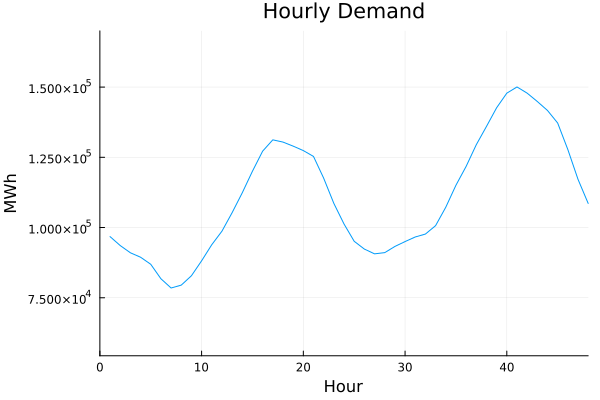

In [74]:
plot(load.Load_MW_z1+load.Load_MW_z2+load.Load_MW_z3+load.Load_MW_z4+load.Load_MW_z5+load.Load_MW_z6, xlims=(0,48) ,label="")
title!("Hourly Demand")
xaxis!("Hour")
yaxis!("MWh")

#print(load.Load_MW_z1)